# Apps project


Did Apple Store apps receive better reviews than Google Play apps?

## Stages of the project

1. Sourcing and loading 
    * Load the two datasets
    * Pick the columns that we are going to work with 
    * Subsetting the data on this basis 
 
 
2. Cleaning, transforming and visualizing
    * Check the data types and fix them
    * Add a `platform` column to both the `Apple` and the `Google` dataframes
    * Changing the column names to prepare for a join 
    * Join the two data sets
    * Eliminate the `NaN` values
    * Filter only those apps that have been reviewed at least once
    * Summarize the data visually and analytically (by the column `platform`)  
  
  
3. Modelling 
    * Hypothesis formulation
    * Getting the distribution of the data
    * Permutation test 


4. Evaluating and concluding 
    * What is our conclusion?
    * What is our decision?
    * Other models we could have used. 
    

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import random

## Stage 1 -  Sourcing and loading data

Read Google data

In [3]:
google='googleplaystore.csv'

Google=pd.read_csv(google)

Google.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [ ]:
Read Apple data 

In [4]:

apple='AppleStore.csv'


Apple=pd.read_csv(apple)

Apple.head(3)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1


### 1b. Pick the columns we'll work with

From the documentation of these datasets, we can infer that the most appropriate columns to answer the brief are:

1. Google:
    * `Category` # Do we need this?
    * `Rating`
    * `Reviews`
    * `Price` (maybe)
2. Apple:    
    * `prime_genre` # Do we need this?
    * `user_rating` 
    * `rating_count_tot`
    * `price` (maybe)

### 1c. Subsetting accordingly

Let's select only those columns that we want to work with from both datasets. We'll overwrite the subsets in the original variables.

In [5]:

Google=Google[['Category', 'Rating', 'Reviews', 'Price']]


Google.head(3)

,Category,Rating,Reviews,Price
0,ART_AND_DESIGN,4.1,159,0
1,ART_AND_DESIGN,3.9,967,0
2,ART_AND_DESIGN,4.7,87510,0


In [6]:

Apple=Apple[['prime_genre', 'user_rating', 'rating_count_tot', 'price']]

Apple.head(3)

,prime_genre,user_rating,rating_count_tot,price
0,Games,4.0,21292,3.99
1,Productivity,4.0,161065,0.00
2,Weather,3.5,188583,0.00


## Stage 2 -  Cleaning, transforming and visualizing

### 2a. Check the data types for both Apple and Google, and fix them 

In [7]:
Apple.dtypes

prime_genre          object
user_rating         float64
rating_count_tot      int64
price               float64
dtype: object

This is looking healthy. But what about our Google data frame?

In [8]:
Google.dtypes

Category     object
Rating      float64
Reviews      object
Price        object
dtype: object

Weird. The data type for the column 'Price' is 'object', not a numeric data type like a float or an integer. Let's investigate the unique values of this column. 

In [9]:
Google['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', 'Everyone', '$1.20', '$1.04'], dtype=object)

There are actually two issues here. 

- Firstly, there's a price called `Everyone`. That is a massive mistake! 
- Secondly, there are dollar symbols everywhere! 

In [12]:
Google.loc[Google['Price']=='Everyone',:]

,Category,Rating,Reviews,Price
10472,1.9,19.0,3.0M,Everyone


Thankfully, it's just one row. We've gotta get rid of it. 

In [22]:
# Let's eliminate that row. 
Google=Google.loc[Google['Price']!='Everyone',:]

Google['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [23]:
 nosymb=Google['Price'].str.replace('$',' ')

Google['Price']=pd.to_numeric(nosymb)

C:\Users\turki\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Now let's check the data types for our Google dataframe again, to verify that the 'Price' column really is numeric now.

In [24]:
Google.dtypes

Category     object
Rating      float64
Reviews      object
Price       float64
dtype: object

Notice that the column `Reviews` is still an object column. We actually need this column to be a numeric column, too. 

In [25]:
 Google['Reviews']=pd.to_numeric(Google['Reviews'])

C:\Users\turki\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
Google.dtypes

Category     object
Rating      float64
Reviews       int64
Price       float64
dtype: object

### 2b. Add a `platform` column to both the `Apple` and the `Google` dataframes
Let's add a new column to both dataframe objects called `platform`: all of its values in the Google dataframe will be just 'google', and all of its values for the Apple dataframe will be just 'apple'. 

The reason we're making this column is so that we can ultimately join our Apple and Google data together, and actually test out some hypotheses to solve the problem in our brief. 

In [27]:
Apple['platform']='apple'
Google['platform']='google'

C:\Users\turki\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 2c. Changing the column names to prepare for our join of the two datasets 

We're going to change the `Apple` columns names to the names of the `Google` columns. 

In [37]:
old_names=Apple.columns

new_names=Google.columns
 
Apple.columns=new_names
Apple.columns

Index(['Category', 'Rating', 'Reviews', 'Price', 'platform'], dtype='object')

### 2d. Join the two datasets 
Let's combine the two datasets into a single data frame called `df`.

In [50]:
 
df=Apple.append(Google)
df.sample(12)

,Category,Rating,Reviews,Price,platform
2588,Book,0.0,0,0.00,apple
1374,HEALTH_AND_FITNESS,4.5,75571,0.00,google
6395,Games,4.5,704,0.00,apple
4652,SOCIAL,4.1,568,0.00,google
3930,Games,4.5,7075,0.00,apple
3876,GAME,4.3,213340,0.00,google
5282,FAMILY,3.7,165,0.00,google
2084,FAMILY,4.4,6356,0.00,google
3901,FAMILY,3.7,353342,0.00,google
1573,Games,3.5,504,2.99,apple


### 2e. Eliminate the NaN values

In [44]:
df.shape

df=df.dropna()
df.shape

(16563, 5)

### 2f. Filter the data so that we only see whose apps that have been reviewed at least once

Apps that haven't been reviewed yet can't help us solve our brief. 

So let's check to see if any apps have no reviews at all. 

In [45]:
df.loc[df['Reviews']==0].count()

Category    929
Rating      929
Reviews     929
Price       929
platform    929
dtype: int64

929 apps do not have reviews, we need to eliminate these points!

In [52]:
df=df.loc[df["Reviews"]!=0,:]
df.dtypes

Category     object
Rating      float64
Reviews       int64
Price       float64
platform     object
dtype: object

### 2g. Summarize the data visually and analytically (by the column `platform`)

What we need to solve our brief is a summary of the `Rating` column, but separated by the different platforms.

In [74]:
df.groupby(by='platform')['Rating'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
apple,6268.0,4.049697,0.726943,1.0,4.0,4.5,4.5,5.0
google,9366.0,4.191757,0.515219,1.0,4.0,4.3,4.5,5.0


Interesting! Our means of 4.049697 and 4.191757 don't **seem** all that different! Perhaps we've solved our brief already: there's no significant difference between Google Play app reviews and Apple Store app reviews. We have an ***observed difference*** here: which is simply (4.191757 - 4.049697) = 0.14206. This is just the actual difference that we observed between the mean rating for apps from Google Play, and the mean rating for apps from the Apple Store. Let's look at how we're going to use this observed difference to solve our problem using a statistical test. 

**Outline of our method:**
1. We'll assume that platform (i.e, whether the app was Google or Apple) really doesn’t impact on ratings. 


2. Given this assumption, we should actually be able to get a difference in mean rating for Apple apps and mean rating for Google apps that's pretty similar to the one we actually got (0.14206) just by: 
a. shuffling the ratings column, 
b. keeping the platform column the same,
c. calculating the difference between the mean rating for Apple and the mean rating for Google. 


3. We can make the shuffle more useful by doing it many times, each time calculating the mean rating for Apple apps and the mean rating for Google apps, and the difference between these means. 


4. We can then take the mean of all these differences, and this will be called our permutation difference. This permutation difference will be great indicator of what the difference would be if our initial assumption were true and platform really doesn’t impact on ratings. 


5. Now we do a comparison. If the observed difference looks just like the permutation difference, then we stick with the claim that actually, platform doesn’t impact on ratings. If instead, however, the permutation difference differs significantly from the observed difference, we'll conclude: something's going on; the platform does in fact impact on ratings. 


6. As for what the definition of *significantly* is, we'll get to that. But there’s a brief summary of what we're going to do.


Let's also get a **visual summary** of the `Rating` column, separated by the different platforms. 

Text(0.5, 1.0, 'Rating by Platform')

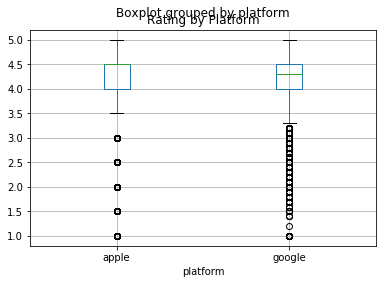

In [59]:
df.boxplot('Rating', by='platform')
plt.title('Rating by Platform')

Here we see the same information as in the analytical summary, but with a boxplot. 

## Stage 3 - Modelling

### 3a. Hypothesis formulation

Our **Null hypothesis** is just:

**H<sub>null</sub>**: the observed difference in the mean rating of Apple Store and Google Play apps is due to chance (and thus not due to the platform).

The more interesting hypothesis is called the **Alternate hypothesis**:

**H<sub>alternative</sub>**: the observed difference in the average ratings of apple and google users is not due to chance (and is actually due to platform)

We're also going to pick a **significance level** of 0.05. 

### 3b. Getting the distribution of the data
Now that the hypotheses and significance level are defined, we can select a statistical test to determine which hypothesis to accept. 

In [64]:
# Create a subset of the column 'Rating' by the different platforms.
apple=df.loc[df['platform']=='apple','Rating']
google=df.loc[df['platform']=='google','Rating']


In [65]:
# Using the stats.normaltest() method, get an indication of whether the apple data are normally distributed
apple_normal=stats.normaltest(apple)
apple_normal

NormaltestResult(statistic=1778.9974234584017, pvalue=0.0)

In [66]:
google_normal=stats.normaltest(google)
google_normal

C:\Users\turki\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\turki\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\turki\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\turki\Anaconda3\lib\site-packages\scipy\stats\stats.py:1463: RuntimeWarning: invalid value encountered in sign
  term2 = np.sign(denom) * np.where(denom == 0.0, np.nan,


NormaltestResult(statistic=nan, pvalue=nan)

Since the null hypothesis of the normaltest() is that the data are normally distributed, the lower the p-value in the result of this test, the more likely the data are to be non-normal. 

Since the p-values is 0 for both tests, regardless of what we pick for the significance level, our conclusion is that the data are not normally distributed. 

(array([  44.,   56.,  106.,  196.,    0.,  383.,  702., 1626., 2663.,
         492.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

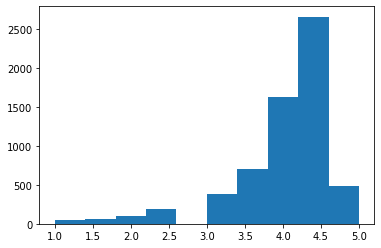

In [67]:
# histogram of the apple reviews distribution
plt.hist(apple)

C:\Users\turki\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\turki\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([  17.,   18.,   41.,   74.,  137.,  446.,  879., 1662., 4175.,
        1917.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

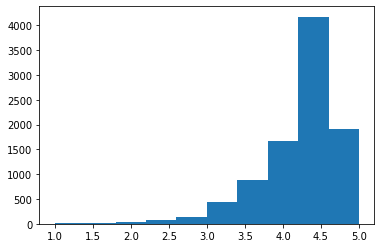

In [68]:
# histogram of the google data
plt.hist(google)

### 3c. Permutation test
Since the data aren't normally distributed, we're using a *non-parametric* test here. This is simply a label for statistical tests used when the data aren't normally distributed. These tests are extraordinarily powerful due to how few assumptions we need to make.  

In [73]:
df['Permutation1']=np.random.permutation(df['Rating'])
 
df.groupby(by='platform')['Permutation1'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
apple,5947.0,4.134135,0.619467,1.0,4.0,4.3,4.5,5.0
google,9687.0,4.135212,0.608951,1.0,4.0,4.3,4.5,5.0


In [79]:
# The difference in the means for Permutation1 (0.001103) now looks hugely different to our observed difference of 0.14206. 
# It's sure starting to look like our observed difference is significant, and that the Null is false; platform does impact on ratings
# But to be sure, let's create 10,000 permutations, calculate the mean ratings for Google and Apple apps and the difference between these for each one, and then take the average of all of these differences.
# Let's create a vector with the differences - that will be the distibution of the Null.


difference=[]


for permutation in range(10000):
    permutation=np.random.permutation(df['Rating'])
difference.append(np.mean(permutation[df['platform']=='apple']) - np.mean(permutation[df['platform']=='google']))

In [81]:
obs_difference = np.mean(apple) - np.mean(google)
 
obs_difference = abs(obs_difference)

obs_difference

0.14206054745123442

## Stage 4 -  Evaluating and concluding
### 4a. What is our conclusion?

In [82]:
'''
What do we know? 

Recall: The p-value of our observed data is just the proportion of the data given the null that's at least as extreme as that observed data.

As a result, we're going to count how many of the differences in our difference list are at least as extreme as our observed difference.

If less than or equal to 5% of them are, then we will reject the Null. 
'''
positiveExtremes = []
negativeExtremes = []
for i in range(len(difference)):
    if (difference[i] >= obs_difference):
        positiveExtremes.append(difference[i])
    elif (difference[i] <= -obs_difference):
        negativeExtremes.append(difference[i])

print(len(positiveExtremes))
print(len(negativeExtremes))

0
0


### 4b. What is our decision?
So actually, zero differences are at least as extreme as our observed difference!

So the p-value of our observed data is 0. 

It doesn't matter which significance level we pick; our observed data is statistically significant, and we reject the Null.

We conclude that platform does impact on ratings. Specifically, we should advise our client to integrate **only Google Play** into their operating system interface. 